<a href="https://colab.research.google.com/github/wolfisberg/zhaw-ba-online/blob/main/High_Performance_Pitch_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import datetime
import os

import numpy as np
import tensorflow as tf
import scipy.interpolate
import matplotlib.pyplot as plt
%load_ext tensorboard


In [3]:
config = {}
config['batch_size'] = 64
config['SNR_range'] = (-5.0,20.0) #dB
config['frame_length'] = 512
config['frame_step'] = 256
config['min_rand_gain'] = 0.05
config['max_rand_gain'] = 1.1
config['sample_length'] = 3 #shorter than shortest noise/speech sample
config['fs'] = 16000
config['num_frames'] = 1 + (config['fs']*config['sample_length'] - config['frame_length']) // config['frame_step']
config['pitch_sampling_time'] = 0.01 # s
config['pitch_confidence_threshold'] = 0.15
config['pitch_frame_length'] = 0.032 # s
seed = 2

In [4]:
parsing_config_noise = {
        'data': tf.io.VarLenFeature(tf.string),
        'data_sampling_rate': tf.io.VarLenFeature(tf.int64),
        'data_num_channels': tf.io.VarLenFeature(tf.int64),
        'data_width': tf.io.VarLenFeature(tf.int64),
        }

def parse_noise_record(serialized_example):
    parsed_features = tf.io.parse_single_example(
        serialized_example, features=parsing_config_noise
    )

    decoded_features = {
        "data_num_channels": tf.cast(parsed_features["data_num_channels"].values[0], tf.int32),
        "data_sampling_rate": tf.cast(parsed_features["data_sampling_rate"].values[0], tf.int32),
        "data_width": tf.cast(parsed_features["data_width"].values[0], tf.int32),
    }
    data = tf.io.decode_raw(parsed_features['data'].values[0], tf.int16)
    decoded_features.update({"data": data})
    return decoded_features

parsing_config_speech = {
        'data': tf.io.VarLenFeature(tf.string),
        'data_sampling_rate': tf.io.VarLenFeature(tf.int64),
        'data_num_channels': tf.io.VarLenFeature(tf.int64),
        'data_width': tf.io.VarLenFeature(tf.int64),
        'pitch': tf.io.VarLenFeature(tf.float32),
        'pitch_confidence': tf.io.VarLenFeature(tf.float32),
        }

def parse_speech_record(serialized_example):
    parsed_features = tf.io.parse_single_example(
        serialized_example, features=parsing_config_speech
    )

    decoded_features = {
        "data_num_channels": tf.cast(parsed_features["data_num_channels"].values[0], tf.int32),
        "data_sampling_rate": tf.cast(parsed_features["data_sampling_rate"].values[0], tf.int32),
        "data_width": tf.cast(parsed_features["data_width"].values[0], tf.int32),
        "pitch": tf.cast(parsed_features['pitch'].values, tf.float32),
        "pitch_confidence": tf.cast(parsed_features['pitch_confidence'].values, tf.float32),
    }
    data = tf.io.decode_raw(parsed_features['data'].values[0], tf.int16)
    decoded_features.update({"data": data})
    return decoded_features

In [5]:
def mix_noisy_speech(speech, noise):   
    speech_pow = tf.math.reduce_euclidean_norm(speech)
    noise_pow = tf.math.reduce_euclidean_norm(noise)

    min_SNR = config['SNR_range'][0]
    max_SNR = config['SNR_range'][1]
    snr_current = 20.0*tf.math.log(speech_pow/noise_pow)/tf.math.log(10.0)
    snr_target = tf.random.uniform((),minval=min_SNR,maxval=max_SNR)

    noise = noise * tf.math.pow(10.0,(snr_current-snr_target)/20.0)
    noisy_speech = speech+noise

    return speech, noise, noisy_speech

In [6]:
def interpolate_pitch(pitch,t):
    pitch = pitch.numpy()
    t = t.numpy()
    t_pitch = np.arange(0, len(pitch))*config['pitch_sampling_time']+config['pitch_frame_length']/2
    f = scipy.interpolate.interp1d(t_pitch, pitch, 'nearest')
    return f(t).astype(np.float32)

@tf.function
def interpolate_pitch_tf(pitch,t):
    y = tf.py_function(interpolate_pitch,[pitch,t], Tout=tf.float32)
    return tf.squeeze(y)


In [7]:
def calc_features(speech_data, noise_data):
    speech = tf.squeeze(tf.cast(speech_data["data"],tf.float32))
    noise = tf.squeeze(tf.cast(noise_data["data"],tf.float32))
    speech = speech/tf.int16.max
    noise = noise/tf.int16.max

    random_start_idx = int(tf.round(tf.random.uniform([],maxval=(tf.cast(len(noise),tf.float32)-config['sample_length']*config['fs']-config['pitch_sampling_time']))))
    noise = noise[random_start_idx:random_start_idx+config['sample_length']*config['fs']]

    random_start_idx = int(tf.round(tf.random.uniform([],minval=161,maxval=(tf.cast(len(speech),tf.float32)-config['sample_length']*config['fs']-161))))
    speech = speech[random_start_idx:random_start_idx+config['sample_length']*config['fs']]

    SNR_range = config['SNR_range']
    frame_length = config['frame_length']
    frame_step = config['frame_step']
    speech, noise, noisy = mix_noisy_speech(speech, noise)
    
    random_gain = tf.math.exp(tf.random.uniform([],minval=tf.math.log(config['min_rand_gain']),maxval=tf.math.log(config['max_rand_gain'])))
    noisy = random_gain*noisy
    
    noisy_frames = tf.signal.frame(noisy,frame_length,frame_step)
    #noisy_stft = tf.signal.stft(noisy,frame_length,frame_step)
    frame_times = random_start_idx/config['fs']+tf.range(0,config['num_frames'])*frame_step/config['fs']+frame_length/config['fs']
    
    pitch = tf.squeeze(speech_data["pitch"])
    pitch_confidence = tf.squeeze(speech_data["pitch_confidence"])
    #pitch = tf.where(pitch_confidence>config['pitch_confidence_threshold'],pitch,0)
    pitch_interpolated = interpolate_pitch_tf(pitch,frame_times)
    return noisy_frames, pitch_interpolated



# Dataset

In [12]:
data_folder = '/content/drive/MyDrive/BA_2021/tfrecords'
speech_data_folder = os.path.join(data_folder,'speech', 'cv')
noise_data_folder = os.path.join(data_folder,'noise', 'cv')

In [13]:
speech_ds = tf.data.TFRecordDataset([os.path.join(speech_data_folder,file) for file in os.listdir(speech_data_folder)])
speech_ds = speech_ds.map(parse_speech_record).repeat(None).shuffle(buffer_size=1000, seed=seed)

noise_ds = tf.data.TFRecordDataset([os.path.join(noise_data_folder,file) for file in os.listdir(noise_data_folder)])
noise_ds = noise_ds.map(parse_noise_record).repeat(None).shuffle(buffer_size=1000, seed=seed)
print('ToDo: Replace speech parser with noise parser')

dataset_combined = tf.data.Dataset.zip((speech_ds, noise_ds))
dataset_features = dataset_combined.map(calc_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_features = dataset_features.batch(config['batch_size'], drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

#dataset_training = dataset_features
dataset_validation = dataset_features
#dataset_test = dataset_features
print('ToDo: add validation and test datasets!')

ToDo: Replace speech parser with noise parser
ToDo: add validation and test datasets!


In [15]:
plt.matshow(a)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: ignored

## Model

In [ ]:
%tensorboard --logdir logs

In [ ]:
#model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.LSTM(256,return_sequences=True, input_shape=(config['num_frames'], config['frame_length'])))
#model.add(tf.keras.layers.LSTM(128,return_sequences=True))
#model.add(tf.keras.layers.Dense(128,activation='relu'))
#model.add(tf.keras.layers.Dense(1,activation='relu'))
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.summary()

In [19]:
from tensorflow.keras import layers
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv1D, ReLU, BatchNormalization,\
                                    AveragePooling1D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(256, 64, input_shape=(config['num_frames'], config['frame_length'])))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(360, activation='softmax'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

In [20]:
def resblock(x, filters, kernelsize, dilationrate):
    fx = layers.Conv1D(filters, kernelsize, dilation_rate=dilationrate, activation='relu', padding='same')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv1D(filters, kernelsize, padding='same')(fx)
    out = layers.Add()([x,fx])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)
    return out

In [29]:
def create_cnn():
    inputs = Input(shape=(config['num_frames'], config['frame_length']))

    #inputs = Reshape(target_shape=(186, 512, 1))(inputs)
    #t = BatchNormalization()(inputs)
    t = Conv1D(filters=128, kernel_size=(64), padding='same')(inputs)
    dilation_rate_list = [1, 2, 4, 8]
    for i in range(len(dilation_rate_list)):
        dilation_rate = dilation_rate_list[i]
        t = resblock(t, 128, 64, dilation_rate)

    t = AveragePooling1D(64)(t)
    t = Flatten()(t)

    outputs = Dense(186, activation='softmax', name="classifier") (t)
    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy')

    return model

    

In [87]:
print(config['num_frames'])
print(config['frame_length'])

186
512


In [30]:
model = create_cnn()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 186, 512)]   0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 186, 128)     4194432     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 186, 128)     1048704     conv1d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 186, 128)     512         conv1d_20[0][0]                  
____________________________________________________________________________________________

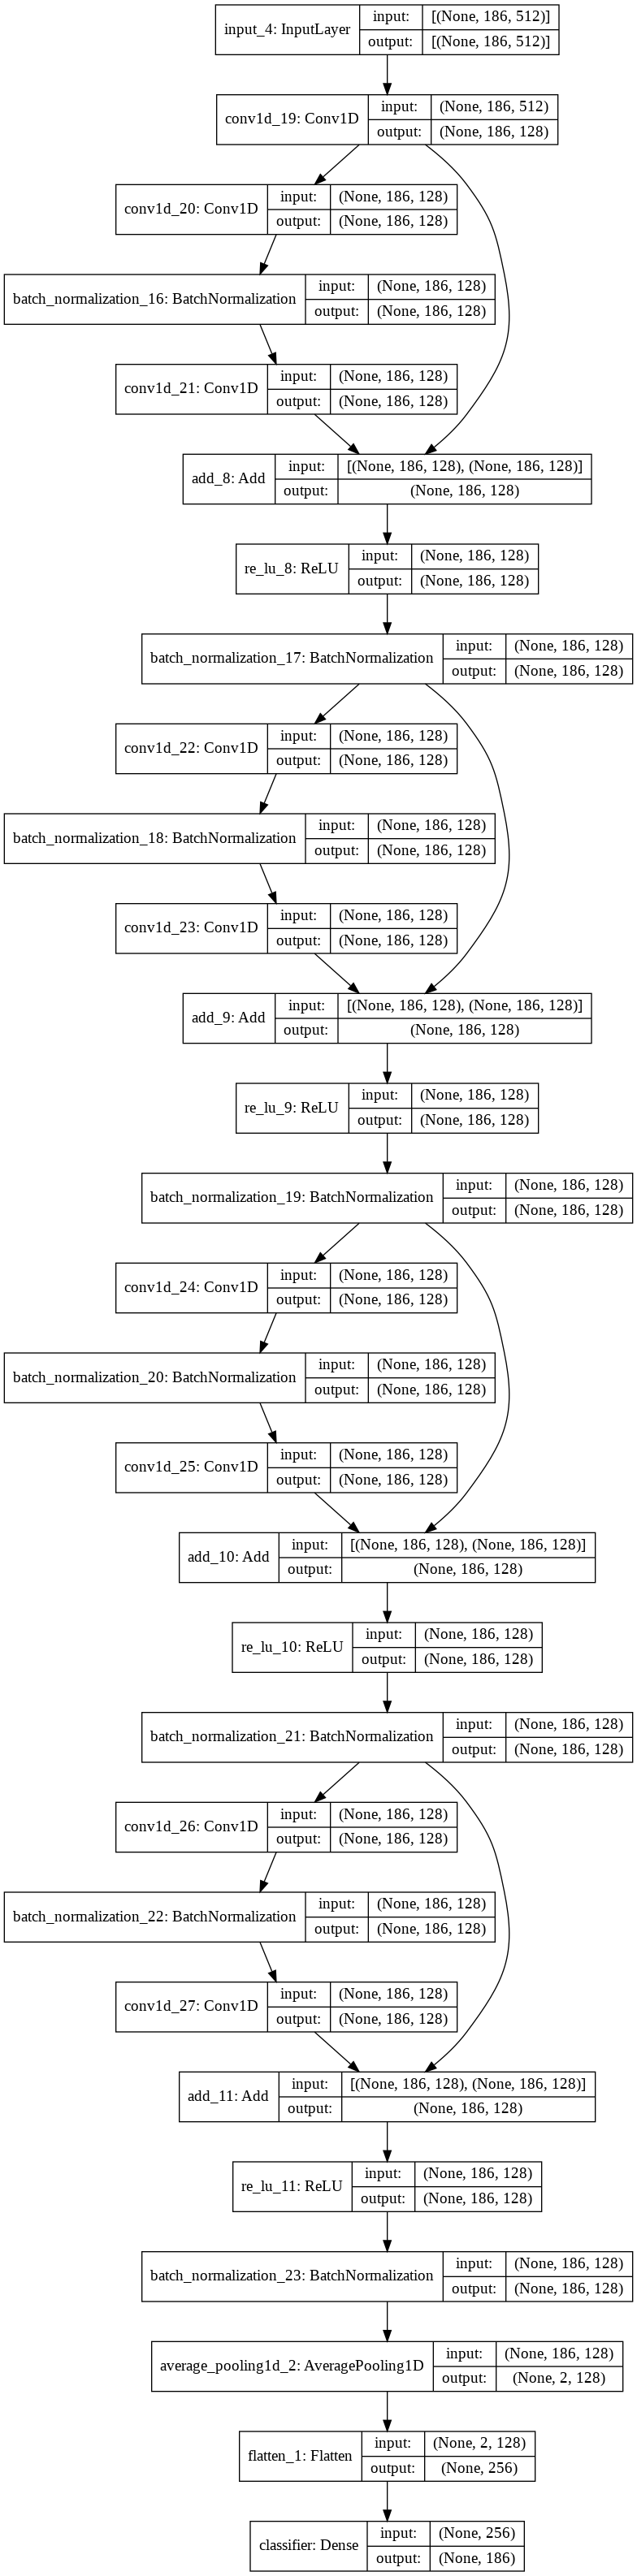

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Train Model

In [27]:
print('ToDo: change paths to google drive --> checkpoints (weights of NNs afer each epoch) etc will be permanently saved there')
date_time_string = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("/content/drive/MyDrive/BA_2021/logs", date_time_string)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

folder = os.path.join('/content/drive/MyDrive/BA_2021/checkpoints', date_time_string)
if not os.path.exists(folder):
    os.makedirs(folder)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(folder,'{epoch:02d}-{val_loss:.2f}.hdf5'))

callbacks = [checkpoint, tensorboard_callback]

ToDo: change paths to google drive --> checkpoints (weights of NNs afer each epoch) etc will be permanently saved there


In [ ]:
history = model.fit(dataset_training, steps_per_epoch=720, epochs=1600, verbose = 1 ,validation_data = dataset_validation, validation_steps=70, callbacks = callbacks)

Epoch 1/1600
720/720 [==============================] - 209s 285ms/step - loss: 263.1393 - val_loss: 239.5849
Epoch 2/1600
720/720 [==============================] - 175s 243ms/step - loss: 250.6195 - val_loss: 236.9782
Epoch 3/1600
284/720 [==========>...................] - ETA: 1:38 - loss: 251.5113